In [1]:
import pandas as pd
from pyts.image import GramianAngularField
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

In [2]:
# Read file
df = pd.read_csv('../structured_data/group_scaled_data/group_scaled_denoised-train.csv')

In [3]:
cols = ["body_acc_x", "body_acc_y", "body_acc_z", "body_gyro_x", "body_gyro_y", "body_gyro_z", "total_acc_x", "total_acc_y", "total_acc_z"]
labels = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

In [4]:
def row_to_df(row):
    """
    Converts a single Series (one sample) with list-like cells into a DataFrame of shape (timesteps, features).
    """
    label = row['label']
    sample_id = row['sample_id']

    data = {}
    for col in cols:
        data[col] = np.fromstring(row[col].strip('[]'), sep=' ')
    df = pd.DataFrame(data)
    return df, label, sample_id

def generate_gaf_images(data, image_size=125, method='difference'):
    """
    Generate Gramian Angular Field (GAF) images for each channel of a single sample.

    Args:
        data (pandas.DataFrame): Data of shape (timesteps, num_features).
        image_size (int): Desired size of the GAF images (image_size x image_size).
        method (str): Method for GAF transformation ('difference' or 'summation').

    Returns:
        numpy.ndarray: GAF images of shape (image_size, image_size, n_channels).
    """
    gaf = GramianAngularField(image_size=image_size, method=method)
    channel_images = []

    for col in data.columns:  # Iterate over each channel
        ts = data[col].values  # Extract the time series for the channel
        ts_reshaped = ts.reshape(1, -1)  # Reshape to 2D array as required by pyts
        img = gaf.fit_transform(ts_reshaped)  # Transform to a GAF image
        channel_images.append(img[0])  # Append the generated image

    return np.stack(channel_images, axis=-1)  # Stack along the last axis to get shape (image_size, image_size, n_channels)

def plot_gaf_images(gaf_images, num_channels=len(cols), label=None):
    """
    Plot the GAF images for each channel of the first sample.

    Args:
        gaf_images (numpy.ndarray): GAF images of shape (n_samples, image_size, image_size, num_features).
        num_channels (int): Number of channels to plot.
    """
    fig, axs = plt.subplots(1, num_channels, figsize=(20, 5))
    for i in range(num_channels):
        axs[i].imshow(gaf_images[0][:, :, i], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Channel {cols[i]}')
    plt.suptitle(label)
    plt.tight_layout()
    plt.show()
    if label is not None:
        os.makedirs('classification_images', exist_ok=True)
        fig.savefig(f'classification_images/{label}.png', bbox_inches='tight')
    else:
        os.makedirs('classification_images', exist_ok=True)
        fig.savefig(f'classification_images/unnamed.png', bbox_inches='tight')


(125, 9)
(125, 125, 9)


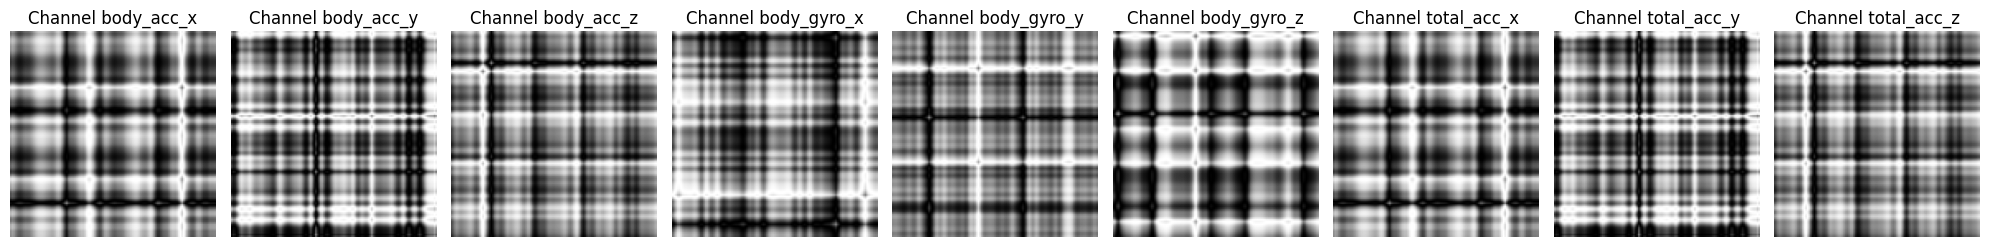

In [5]:
def get_data_by_label(df: pd.DataFrame, label: int, n: int) -> pd.DataFrame:
    """
    Get n random samples of data by label.
    """
    return df[df['label'] == label].sample(n=n, random_state=40)

label = 0
sample = get_data_by_label(df, label, 1).iloc[0]
sample, _, _ = row_to_df(sample)
print(sample.shape)
sample = generate_gaf_images(sample)
print(sample.shape)
plot_gaf_images([sample])

In [6]:
x = []
y = df['label'].values
for i in tqdm(range(len(y)), desc="Generating GAF images"):
    sample = df.iloc[i]
    sample, label, sample_id = row_to_df(sample)
    sample = generate_gaf_images(sample)
    x.append(sample)
print("Extracted features shape:", np.array(x).shape)
x = np.array(x)

Generating GAF images: 100%|██████████| 7352/7352 [00:49<00:00, 148.09it/s]


Extracted features shape: (7352, 125, 125, 9)


In [7]:
# Export the features and labels
np.savez_compressed('GAF-group_scaled_denoised-train.npz', x=x, y=y)